C:\Users\Max\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


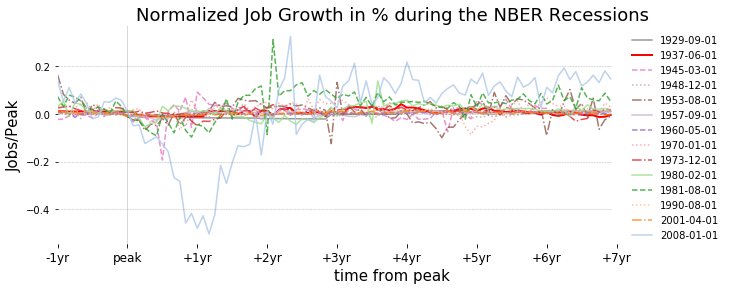

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data, wb
import datetime

start = datetime.datetime(1929, 8, 1)
end = datetime.datetime(2016,10,1)
nber = data.DataReader('USREC', 'fred', start, end)
payems1 = data.DataReader('PAYEMS', 'fred', start, end)
payems = pd.read_csv(r"C:\Users\Max\Documents\OSM_BootCampExercises\Computation\Wk2_Visualization\payems.csv",
                  skiprows=5, parse_dates=True)

len(nber[:'1938-12-01'])
early = payems[:11]
early['num'] = np.concatenate([np.arange(1,10*12, step=12), np.array([114])])
vals = np.arange(2, 115)
payems_interpl = np.interp(vals, early.num, early.payems)
len(payems_interpl)
payems_long = np.concatenate((payems_interpl, payems1.PAYEMS.values))
len(payems_long)
nber['payems'] = payems_long
nber['pay_gr'] = np.log(nber.payems) - np.log(nber.payems.shift(1))

nber['count'] = np.arange(len(nber))
w = np.concatenate([np.array([0]), nber.USREC.values])
group_split = np.array([ i for i, (x, y) in enumerate(zip(w[:-1],w[1:])) if x!=y])
groups = group_split.copy().reshape((14, 2))

#peaks = np.zeros(14, dtype=int)
#for i,group in enumerate(groups):
#    recession = nber.pay_gr.iloc[group[0]:group[1]]
#    peaks[i] =  np.where(nber.pay_gr == recession.max())[0][0]
#    del(recession)

select = np.zeros([len(nber), 14], dtype=bool)
for i,s  in enumerate(groups[:,0]):
    if s < 12:
        select[0:s+(12*7),i] = True
    else:
        select[s-12:s+(12*7),i] = True

lenGR = select[:,0].sum()

peak_dates = list(nber.index[groups[:,0]].astype(str))
recessions = pd.DataFrame(np.zeros((96, 14)), columns=peak_dates)
for i in range(14):
    col = peak_dates[i]
    this_recession = select[:,i]
    vals = nber.pay_gr[this_recession].values
    vals = vals[~np.isnan(vals)]
    if i == 0:
        subset = 1
    else:
        subset = 12
    scale = abs(vals[subset])
    vals_norm = vals / (scale * 100)
    if i == 0:
        vals_norm = np.concatenate((np.repeat(np.nan,12), vals_norm))
    recessions[col] = vals_norm

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

new_ticks = ['-1yr', 'peak', '+1yr', '+2yr',
             '+3yr', '+4yr', '+5yr', '+6yr', '+7yr']

recessions.columns = nber.iloc[list(groups[:,0])].index.astype(str)
#%%
from itertools import cycle
linestyles = ['-', '--', ':', '-.', ]
linecycler = cycle(linestyles)
ticks_pos = np.arange(0, 97, step=12)

fig, ax = plt.subplots(figsize=(12,4));
for i, rec in enumerate(recessions.columns):
    if i == 1:
        ax.plot(recessions[rec], '-', lw=2, label=rec, color='red')
    elif i == 14:
        ax.plot(recessions[rec], '-', lw=2, label= rec, color='black')
    else:
        ax.plot(recessions[rec], next(linecycler), label=rec, alpha=0.8, color=tableau20[-i-6])
ax.set_xlim(0, 115)
for y in np.arange(-0.4, 0.3, 0.2):    
    ax.plot(np.arange(0, 96), np.repeat(y, 96), "--", lw=0.5, color="black", alpha=0.3) 
    
plt.axvline(12, ymin=-0.6, ymax = 1.1, linewidth=0.5, alpha=0.3, color='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#ax.spines['bottom'].set_bounds(0, 96)
ax.set_xlabel('time from peak', fontsize=15)
ax.set_ylabel('Jobs/Peak', fontsize=15)
ax.set_xticks(ticks_pos)
# Set ticks labels for x-axis
ax.set_xticklabels(new_ticks, fontsize=12)
ax.set_xticks(ticks_pos, new_ticks)
plt.title('Normalized Job Growth in % during the NBER Recessions', fontsize=18)
plt.legend(frameon=False)
plt.show();

#### Note:
I think I got the excersise a litle wrong and plotttedd log-differences instead of the levels, because it sead "job growth" in the first part.

### Answers:

Actuallly the Great Recessin starting in 2008-01-01 has been the worst interms of negative job growth rate compared to the job gropwth rate at the beginnning of the recession.